In [55]:
import os, sys
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from contextlib import contextmanager

import matplotlib.pyplot as plt

# Extract flash frames

Fill in the path to the video files and the names of each file that you want to process.

In [44]:
videopath = "Raw data/flash"
filenames = ["left-20241104-GX010053.MP4",
            #  "left-20241104-GX010054-clip1.mp4",
            #  "left-20241104-GX010054-clip2.mp4",
             "right-20241104-GX010050.MP4",
            #  "right-20241104-GX010051-clip1.mp4",
            #  "right-20241104-GX010051-clip2.mp4"]
]

This sets up a simple way to open and close video files

In [40]:
@contextmanager
def VideoCapture(*args, **kwargs):
    cap = cv2.VideoCapture(*args, **kwargs)
    try:
        yield cap
    finally:
        cap.release()

Run through each frame of each video and extract the mean intensity

In [45]:
intensities = []

for filename in filenames:
    print(f"File {filename}")
    with VideoCapture(os.path.join(videopath, filename)) as cap:
        nfr = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        intensity = np.zeros((nfr,))

        for fr in trange(nfr):
            flag, frame = cap.read()

            if not flag:
                print(f"Trouble reading frame {fr}")
                break
                
            intensity[fr] = np.mean(frame)    
        
        intensities.append(intensity)

File left-20241104-GX010053.MP4


100%|██████████| 729/729 [00:12<00:00, 60.45it/s]


File right-20241104-GX010050.MP4


100%|██████████| 1249/1249 [00:55<00:00, 22.52it/s]


Show the plots of intensity

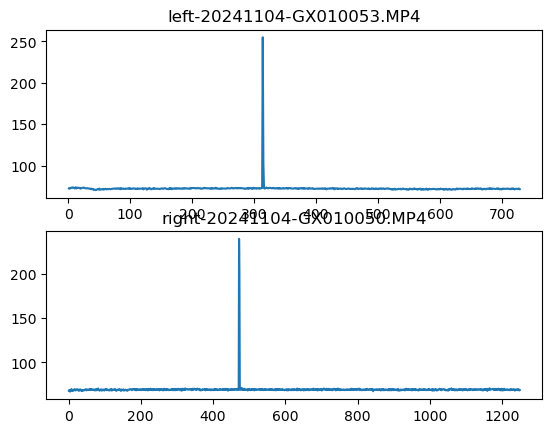

In [52]:
fig, ax = plt.subplots(len(filenames), 1)

for ax1, intent1, fn1 in zip(ax, intensities, filenames):
    frame = np.arange(1, len(intent1)+1)
    ax1.plot(frame, intent1)
    ax1.set_title(fn1)

Fill in a threshold for the flash. The images should range from 0 to 255, so something over 200 is probably appropriate.

In [90]:
threshold = 220

Then extract the frame(s) from each video that has intensities over the threshold, and make a data frame with the values.

In [91]:
flashframes = []
dfflash = []
for intens1, fn1 in zip(intensities, filenames):
    ff1 = np.argwhere(intens1 > threshold)
    df1 = pd.DataFrame({"filename": fn1, "flashframe": ff1.flatten()})

    flashframes.append(ff1.flatten())
    dfflash.append(df1)

dfflash = pd.concat(dfflash)

In [92]:
dfflash

,filename,flashframe
0,left-20241104-GX010053.MP4,313
0,right-20241104-GX010050.MP4,471


And save the flash frames!

In [93]:
outfile = os.path.join(videopath, "flashframes.csv")
dfflash.to_csv(outfile)

## Debug images

(Optional below here)

Pull out the flash frames and the preceeding frame so that we can check that they seem to be right.

In [94]:
images = []
titles = []
for fn1, ff1 in zip(filenames, flashframes):
    with VideoCapture(os.path.join(videopath, fn1)) as cap:
        for fr in ff1:
            # get the frame before the flash
            cap.set(cv2.CAP_PROP_POS_FRAMES, fr-1)
            flag, I1 = cap.read()

            # and the flash frame
            flag, I2 = cap.read()
            
            images.append([I1, I2])
            titles.append(fn1)

Text(0.5, 1.0, 'Flash')

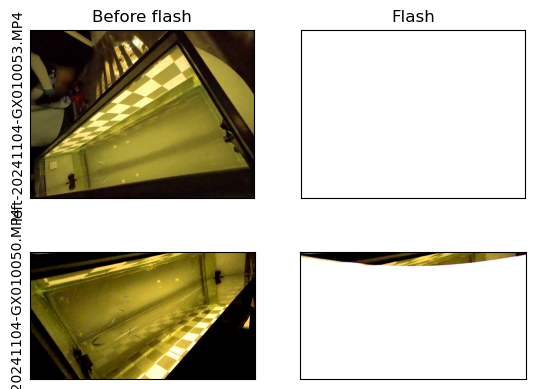

In [95]:
fig, ax = plt.subplots(len(images), 2)
if len(images) == 1:
    ax = np.array([ax]).T
for ax1, Ipair, title1 in zip(ax, images, titles):
    ax1[0].imshow(Ipair[0])
    ax1[1].imshow(Ipair[1])

    # ax1[0].set_title(title1)
    ax1[0].set_xticks([])
    ax1[0].set_yticks([])
    ax1[0].set_ylabel(title1)

    ax1[1].set_xticks([])
    ax1[1].set_yticks([])

ax[0,0].set_title('Before flash')
ax[0,1].set_title('Flash')